In [1]:
cd ../

/Users/joepalmo/Desktop/cfa/SDU-preproc


In [2]:
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.io import fits
from astropy.table import Table
import os

# open source module found for converting MJD/JD to DateTimes
import jdutil as jd

# Ben's module -- THANKS BEN
import LCtools

# my preprocessing module
from preproc import *

import glob

from importlib import reload
reload(LCtools)

<module 'LCtools' from '/Users/joepalmo/Desktop/cfa/SDU-preproc/LCtools.py'>

In [3]:
# specify path to the lightcurve and spectrum
lc_path = "BYDra/263.471_16.9203_ZTFlc.fits"
spec_path = "BYDra/0162.lspm3642.ms.csv"

# object name (or abbreviation)
n = "BYDra"

# resample length for time-sorted LC purposes
resample_len = '2d'

# LC Data Munging

In [4]:
lc_table = Table.read(lc_path)
lc = lc_table[['mjd', 'mag', 'filtercode']].to_pandas()
lc = lc[lc.filtercode == b'zr']

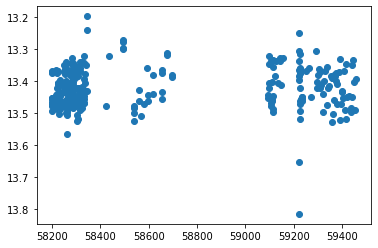

In [5]:
#raw data
plt.scatter(lc['mjd'], lc['mag'])
plt.gca().invert_yaxis()

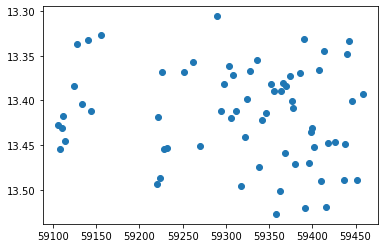

In [6]:
#resampled data
time_preproc_lc = LC_timesort_preproc(lc, resample_len=resample_len)
time_preproc_lc = time_preproc_lc[time_preproc_lc['Modified Julian Day'].between(59100, 59500)]
plt.scatter(time_preproc_lc['Modified Julian Day'], time_preproc_lc['Magnitude'])
plt.gca().invert_yaxis()

In [7]:
# number of data points covers
len(time_preproc_lc.dropna())

67

In [8]:
# The average data play rate determined empirically from sonoUno is about 
# 8.5 data rows played per second. Therefore:
print("Estimated video time of "+ str(len(time_preproc_lc) / 8.5), "s")

Estimated video time of 21.176470588235293 s


# Spectra Data Munging

In [9]:
spec_table = Table.read(spec_path, names=('wavelength', 'flux'), delimiter=' ')
spec = spec_table[['wavelength', 'flux']].to_pandas()

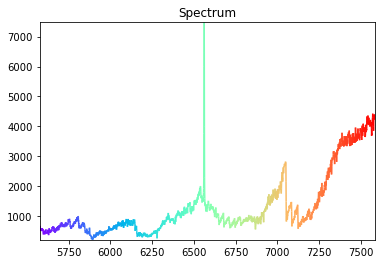

In [10]:
#raw data
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
fig, ax = plt.subplots()
x,y = spec['wavelength'], spec['flux']
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='rainbow', norm=norm)
lc.set_array(x)
ax.add_collection(lc)
ax.set_title('Spectrum')
plt.show()

In [11]:
spec

,wavelength,flux
0,5576.195355,527.338257
1,5576.944420,602.196472
2,5577.693486,683.213867
3,5578.442551,534.025879
4,5579.191617,555.652161
...,...,...
2675,7579.945616,4317.743652
2676,7580.694682,4386.053223
2677,7581.443747,4228.838867
2678,7582.192813,4280.450195


In [12]:
preproc_spec = spectra_preproc(spec, bins=np.arange(5550,7600,10))

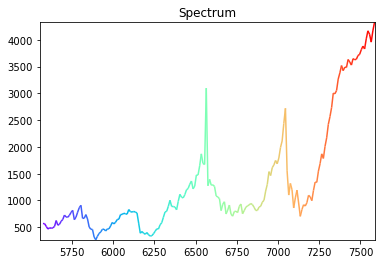

In [13]:
#preprocessed
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
fig, ax = plt.subplots()
x,y = preproc_spec['Wavelength'], preproc_spec['Flux']
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='rainbow', norm=norm)
lc.set_array(x)
ax.add_collection(lc)
ax.set_title('Spectrum')
plt.show()

# Phased Light Curve

In [14]:
lc_path = "BYDra/263.471_16.9203_ZTFlc.fits"

#load data into astropy table, sort by mjd, and remove phase
lc_table = Table.read(lc_path)
lc_table = lc_table[lc_table['filtercode'] == 'zg']
#lc_table['phase'] = 0

# removing outliers in this way...I'm just more comfortable with pandas syntax
df = lc_table.to_pandas()
#df = df[df['mag'] > 14.8]
lc_table = Table.from_pandas(df)

# write .fits table to .csv
lc_table.write('BYDra/lc.csv', format='ascii.csv', overwrite=True)

# # load in as ascii table
data = ascii.read('BYDra/lc.csv', format='csv', fast_reader=False)
data.sort('mjd')

flc_data, LC_stat_properties = LCtools.process_LC(data, fltRange=5.0, detrend=True, detrend_deg=2)
goodQualIndex = np.where(flc_data['QualFlag'] == 1)[0]
filtered = flc_data[goodQualIndex]
# #Use LombScargle periodogram to find the best fit period (in days)
period = LCtools.perdiodSearch(filtered)
omega = period[1]['P'] 

In [15]:
flc_data.to_pandas()['QualFlag'].value_counts()

True     271
False      7
Name: QualFlag, dtype: int64

In [16]:
print("The period is", omega, "days")

The period is 0.26594047188477327 days


In [17]:
try:
    goodQualIndex = np.where(flc_data['QualFlag'] == 1)[0]
    lc_mjd = flc_data['mjd'][goodQualIndex]
    lc_mag = flc_data['mag'][goodQualIndex]
    lc_err = flc_data['magerr'][goodQualIndex]
except:
    lc_mjd = flc_data['mjd']
    lc_mag = flc_data['mag']
    lc_err = flc_data['magerr']

data_tuple = (lc_mjd, lc_mag, lc_err,)

lc_phase = LCtools.AFD(data_tuple, omega)[3]

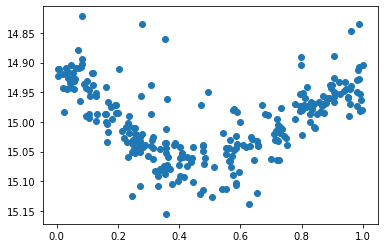

In [18]:
plt.scatter(lc_phase, lc_mag)
plt.gca().invert_yaxis()

In [19]:
#phase_preproc_lc = LC_phasesort_preproc(lc, bins=phase_bins())
phasefit_preproc_lc = LC_phasefit_preproc('BYDra/lc.csv', bins=phase_bins())

0.26594047188477327


In [20]:
phasefit_preproc_lc

,Phase,Magnitude
0,0.005,14.927432
1,0.015,14.927810
2,0.025,14.928595
3,0.035,14.929784
4,0.045,14.931375
...,...,...
195,1.955,14.931434
196,1.965,14.929883
197,1.975,14.928694
198,1.985,14.927881


Text(0, 0.5, 'ZTF g mag')

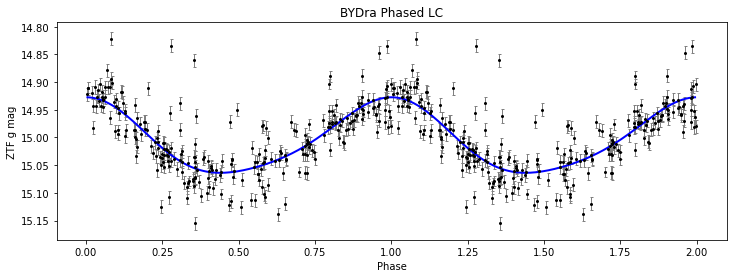

In [21]:
fig = plt.figure(figsize=(12,4))
plt.errorbar(lc_phase, lc_mag, lc_err, fmt='.k', ecolor='gray', lw=1, ms=4, capsize=1.5)
plt.errorbar(lc_phase+1, lc_mag, lc_err, fmt='.k', ecolor='gray', lw=1, ms=4, capsize=1.5)
plt.plot(phasefit_preproc_lc['Phase'], phasefit_preproc_lc['Magnitude'], 'b', markeredgecolor='b', lw=2, fillstyle='top', linestyle='solid')
plt.gca().invert_yaxis()
plt.title("BYDra Phased LC")
plt.xlabel("Phase")
plt.ylabel("ZTF g mag")

In [ ]:
def LC_phasefit_preproc(path_to_lc, bins=None, rephased=False):
    '''
    Function used to fit a phase curve to tabular LC data before inputting them into sonoUno. This is
    done by using a LombScargle periodogram to obtain a period value, then using a Fourier Decomposition
    to make the best fit. 

    Inputs ----------------------
        :param path_to_lc: path to .csv with columns mjd, phase, and magnitude
        :type path_to_lc: str
        :kwarg bins: phase bins to average over
        :type bins: array-like
            
    Returns ---------------------
        df - phase fit dataframe. Turn this into a .csv and input into sonoUno

    '''

    #load data into astropy table, sort by mjd, and remove phase
    data = ascii.read(path_to_lc, format='csv', fast_reader=False)
    data.sort('mjd')
    try:
        data.remove_column('phase')
    except:
        pass
    
    flc_data, LC_stat_properties = LCtools.process_LC(data, fltRange=5.0, detrend=False)
    #Use LombScargle periodogram to find the best fit period (in days)
    omega = LCtools.perdiodSearch(flc_data)[0]['P'] 
    print(omega)
    
    #use QualFlag if the data has been processed with process_LC
    try:
        goodQualIndex = np.where(flc_data['QualFlag'] == 1)[0]
        lc_mjd = flc_data['mjd'][goodQualIndex]
        lc_mag = flc_data['mag'][goodQualIndex]
        lc_err = flc_data['magerr'][goodQualIndex]
    except:
        lc_mjd = flc_data['mjd']
        lc_mag = flc_data['mag']
        lc_err = flc_data['magerr']

    #restructure data for input to AFD
    # data_tuple = (flc_data['mjd'], flc_data['mag'], flc_data['magerr'],)
    data_tuple = (lc_mjd, lc_mag, lc_err,)
    
    #Run the Automatic Fourier Decomposition to find the best phase fit
    best_Nterms, best_phase_fit, best_y_fit, best_phased_t, best_resid, best_reduced_ChiSq, best_mtf = LCtools.AFD(data_tuple, omega)
    
    #stack into 2d array
    arr = np.vstack((best_phase_fit, best_y_fit)).T
 
    # bin by phase -> 100 points
    s, edges, _ = binned_statistic(arr[:,0],arr[:,1], statistic='mean', bins=bins)
    bincenters = edges[:-1]+np.diff(edges)/2
    
    # 2 phases
    bincenters = np.append(bincenters, bincenters+1)
    s = np.append(s, s)
    
    #to df - name columns
    new_arr = np.vstack((bincenters, s)).T
    df = pd.DataFrame(new_arr, columns = ['Phase', 'Magnitude'])

    if rephased is True:
        rephase = df[df.Phase.between(0.505, 1.495)]['Magnitude'].to_numpy()
        rephase = np.append(rephase, rephase)
        rephase_arr = np.vstack((bincenters, rephase)).T
        rephase_df = pd.DataFrame(rephase_arr, columns=['Phase', 'Magnitude'])

        return rephase_df
    
    return df

In [66]:
def qualFlagData(flc_data):
    """
    Flexible function used to filter data regardless of whether process_LC has been run yet. Data tuple
    that can be input into AFD is also constructed.
    """
    try:
        goodQualIndex = np.where(flc_data['QualFlag'] == 1)[0]
        lc_mjd = flc_data['mjd'][goodQualIndex]
        lc_mag = flc_data['mag'][goodQualIndex]
        lc_err = flc_data['magerr'][goodQualIndex]
        filtered_data = flc_data[goodQualIndex]
    except:
        lc_mjd = flc_data['mjd']
        lc_mag = flc_data['mag']
        lc_err = flc_data['magerr']
        filtered_data = flc_data

    data_tuple = (lc_mjd, lc_mag, lc_err)

    return filtered_data, data_tuple

def format_df(arr, bins, rephased):
    """
    Function used to format phased LC data into a pandas df that can be input into sonoUno. This means
    binning, averaging, and extending x-axis across 2 phases.
    """
    # bin by phase -> 100 points
    s, edges, _ = binned_statistic(arr[:,0],arr[:,1], statistic='mean', bins=bins)
    bincenters = edges[:-1]+np.diff(edges)/2
    
    # 2 phases
    bincenters = np.append(bincenters, bincenters+1)
    s = np.append(s, s)
    
    #to df - name columns
    new_arr = np.vstack((bincenters, s)).T
    df = pd.DataFrame(new_arr, columns = ['Phase', 'Magnitude'])

    if rephased is True:
        rephase = df[df.Phase.between(0.505, 1.495)]['Magnitude'].to_numpy()
        rephase = np.append(rephase, rephase)
        rephase_arr = np.vstack((bincenters, rephase)).T
        rephase_df = pd.DataFrame(rephase_arr, columns=['Phase', 'Magnitude'])

        return rephase_df
    
    return df

In [67]:
from astropy.table import Table

def phase_LC(data, bins=None, rephased=False, **kwargs):
    '''
    Function used to fit a phase curve to tabular LC data before inputting them into sonoUno. This is
    done by using a LombScargle periodogram to obtain a period value, then using a Fourier Decomposition
    to make the best fit. 

    Inputs ----------------------
        :param data: pandas df with columns mjd, mag, magerr, (and optional phase)
        :type data: pandas DataFrame
        :kwarg bins: phase bins to average over
        :type bins: array-like
        :kwarg rephased: if True, move the data over by 0.5 phases
        :type rephased: boolean
            
    Returns ---------------------
        phasefit_df - phase fit dataframe. Turn this into a .csv and input into sonoUno
        phasesort_df - phase sorted dataframe. Turn this into a .csv and input into sonoUno
        period - period in days
    '''
    # option to filter data or not
    # example of a time we wouldn't want to filter would be for phasing data with random flares
    flc = kwargs.pop("flc", False)
    # process_LC inputs
    detrend = kwargs.pop("detrend", False)
    fltRange =  kwargs.pop("fltRange", 5.0)
    detrend_deg = kwargs.pop("detrend_deg", 3)

    #pandas to astropy table, to be compatible with Ben's code. Sort by mjd, remove phase if applicable
    lc_table = Table.from_pandas(df)   
    lc_table.sort('mjd')
    try:
        lc_table.remove_column('phase')
    except:
        pass

    #filter data and find period
    if flc == True:
        flc_data, LC_stat_properties = LCtools.process_LC(lc_table, fltRange=fltRange, detrend=detrend, detrend_deg=detrend_deg)
    else:
        flc_data = lc_table

    #Use LombScargle periodogram to find the best fit period (in days)
    filtered_data, data_tuple = qualFlagData(flc_data)
    omega = LCtools.perdiodSearch(filtered_data)[0]['P'] 

    #Run the Automatic Fourier Decomposition to find the best phase fit
    best_Nterms, best_phase_fit, best_y_fit, best_phased_t, best_resid, best_reduced_ChiSq, best_mtf = LCtools.AFD(data_tuple, omega)

    #stack phasefit into 2d array
    phasefit_arr = np.vstack((best_phase_fit, best_y_fit)).T

    #stack phasesort into 2d array
    phasesort_arr = np.vstack((best_phased_t, data_tuple[1])).T

    #restructure to be in sonoUno format
    phasefit_df = format_df(phasefit_arr, bins=bins, rephased=rephased)
    phasesort_df = format_df(phasesort_arr, bins=bins, rephased=rephased)
    
    return omega, phasesort_df, phasefit_df

In [77]:
lc_path = "BYDra/263.471_16.9203_ZTFlc.fits"

#load data into astropy table, sort by mjd, and remove phase
lc_table = Table.read(lc_path)
lc_table = lc_table[lc_table['filtercode'] == 'zg']
#lc_table['phase'] = 0

# I'm just more comfortable with pandas syntax
df = lc_table.to_pandas()
period, phasesort_df, phasefit_df = phase_LC(df, bins=phase_bins(), rephased=False, flc=True, detrend=True, detrend_deg=2)

Text(0, 0.5, 'ZTF g mag')

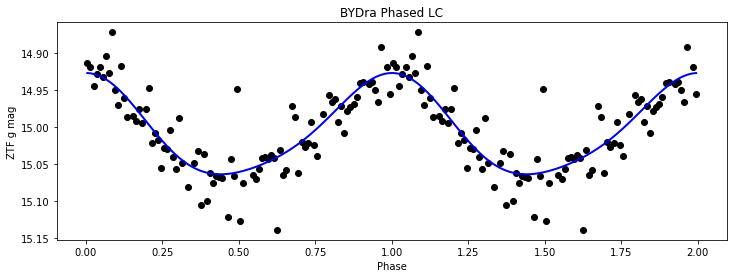

In [78]:
fig = plt.figure(figsize=(12,4))
plt.scatter(phasesort_df['Phase'], phasesort_df['Magnitude'], c='k', marker='o')
plt.plot(phasefit_df['Phase'], phasefit_df['Magnitude'], 'b', markeredgecolor='b', lw=2, fillstyle='top', linestyle='solid')
plt.gca().invert_yaxis()
plt.title("BYDra Phased LC")
plt.xlabel("Phase")
plt.ylabel("ZTF g mag")

In [83]:
# change flc to False, so that i generate a phasesort_df that includes stellar flare outlier points --> they are real data after all!
period, phasesort_df1, phasefit_df1 = phase_LC(df, bins=phase_bins(), rephased=False, flc=False, detrend=True, detrend_deg=2)

Text(0, 0.5, 'ZTF g mag')

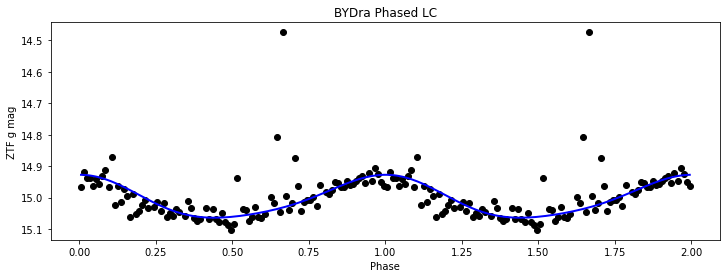

In [84]:
fig = plt.figure(figsize=(12,4))
plt.scatter(phasesort_df1['Phase'], phasesort_df1['Magnitude'], c='k', marker='o')
plt.plot(phasefit_df['Phase'], phasefit_df['Magnitude'], 'b', markeredgecolor='b', lw=2, fillstyle='top', linestyle='solid')
plt.gca().invert_yaxis()
plt.title("BYDra Phased LC")
plt.xlabel("Phase")
plt.ylabel("ZTF g mag")

# Export Preprocessed Files

In [81]:
#create output directory
outdir = 'preproc/{}/'.format(n)
if not os.path.exists(outdir):
    os.makedirs(outdir)   

In [82]:
#save preprocessed files
time_preproc_lc.to_csv("preproc/{}/{}_LC_timesort.csv".format(n,n), index=False)
phasesort_df1.to_csv("preproc/{}/{}_phasesort.csv".format(n,n), index=False)
phasefit_df.to_csv("preproc/{}/{}_phasefit.csv".format(n,n), index=False)
preproc_spec.to_csv("preproc/{}/{}_spec.csv".format(n,n), index=False)